Использую метод Монте-Карло, чтобы оценить результат своего портфеля на дистанции 3 лет.
То, как работает функция data_for_compare, мне не очень нравится. Буду ее переписывать.

upd. Понял, что это единственный вариант получить что-то похожее на правду.

In [67]:
from pandas_datareader import data as wb
import datetime as dt
from datetime import datetime
from pandas_datareader._utils import RemoteDataError
from pytz import timezone

In [68]:
import pandas as pd
import numpy as np

In [69]:
from tqdm import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt

In [70]:
from ipynb.fs.defs.portfolio_analysis import api_connect, get_id, get_portfolio,data_for_compare, usd_cur

In [71]:
def monte_carlo(data):
    
    log_returns = np.log(1 + data.pct_change())
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()
    t_intervals = 3*365
    iterations = 1000
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals,iterations)))
    S0 = data.iloc[-1]
    
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0
    
    for t in range(1, t_intervals):
        price_list[t] = price_list[t-1]*daily_returns[t]
        
    return np.median(price_list)

In [72]:
f = open('../tokens.txt')
token = f.read()
token = token[:-1]

In [73]:
client = api_connect(token)

In [74]:
broker, iis = get_id(client)

In [75]:
usd = usd_cur(client)

In [76]:
df = get_portfolio(client,iis, usd)

In [77]:
df = df[((df['ticker'] != 'USD000UTSTOM') & (df['ticker'] != 'EUR_RUB__TOM'))]

In [84]:
ticks = df[['ticker', 'n_shares']]
ticks = ticks.set_index('ticker')
ticks = ticks.sort_values(by=['n_shares'])

In [85]:
data = data_for_compare(ticks)

In [86]:
meds = list()
for _ in tqdm(range(1000)):
    meds.append(monte_carlo(data))

100%|██████████| 1000/1000 [01:18<00:00, 12.79it/s]


In [87]:
print(np.min(meds), np.max(meds), np.median(meds))

6198.854974851143 7125.289839678271 6630.639176884097


<AxesSubplot:xlabel='Date'>

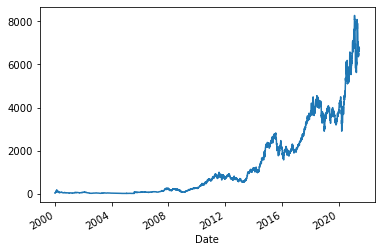

In [88]:
data.plot()